In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, N):
    dt = 1 / trading_days  # Time increment based on trading days per year
    n_steps = int(T / dt)  # Number of time steps
    paths = np.zeros((n_steps + 1, N))
    paths[0] = S0

    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    drift = (r - 0.5 * sigma ** 2) * dt

    # Simulate the paths
    for t in range(1, n_steps + 1):
        # Standard normal random numbers for GBM
        Z = np.random.standard_normal(N)
        
        # Poisson random numbers for jumps
        J = np.random.poisson(lam * dt, N)
        
        # Normally distributed jump sizes
        Y = np.random.normal(mu_J, sigma_J, N)
        
        # Calculate the compound jump component
        compound_jump = J * Y
        
        # Update the paths
        paths[t] = paths[t - 1] * np.exp(drift + sigma * sqrt_dt * Z + compound_jump)

    return paths

In [3]:


def generate_black_scholes_paths(S0, r, sigma, T, dt, num_paths):
    """
    Generate Black-Scholes paths using geometric Brownian motion.

    Args:
    S0 (float): Initial stock price.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    T (float): Time to maturity in years.
    dt (float): Time step in years.
    N (int): Number of time steps.
    num_paths (int): Number of paths to simulate.

    Returns:
    numpy.ndarray: Simulated paths of shape (N+1, num_paths).
    """
    n_steps = int(T / dt)  # Total number of time steps
    paths = np.zeros((n_steps + 1, num_paths))
    paths[0] = S0

    # Generate increments of a standard Brownian motion
    # Normal random variables for all paths and time steps
    dW = np.random.normal(0, np.sqrt(dt), (n_steps, num_paths))

    # Precompute constant factors for the exponent
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * dW

    # Compute the paths
    for t in range(1, n_steps + 1):
        paths[t] = paths[t-1] * np.exp(drift + diffusion[t-1])

    return paths


In [40]:

from scipy.stats import norm

# Define the cumulative distribution function of a normal distribution
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r * T) * N(d2)

def BS_PUT(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * N(-d2) - S * N(-d1)

def merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European call option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the call option.
    """
    if T <= 0:
        return max(S - K, 0)
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_CALL(S, K, T, r_k, sigma_k)
    return price

def merton_jump_put(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European put option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the put option.
    """
    if T <= 0:
        return max(K - S, 0)
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_PUT(S, K, T, r_k, sigma_k)
    return price


In [5]:
def BS_delta(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the delta of a European option.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    option_type (str): Type of the option ('call' or 'put').

    Returns:
    float: Delta of the option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return N(d1)
    else:  # for put option
        return N(d1) - 1

In [11]:


def dynamic_hedge_simulation_3(paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost):
    N = paths.shape[1]
    n_steps = paths.shape[0] - 1
    B0 = 1  # Initial bond price
    
    portfolio_values = np.zeros_like(paths)
    relative_pnl = np.zeros(N)
    
    for j in range(N):  # Loop over each simulation path
        cash = 0
        stock_held = 0
        bond_held = B0
        initial_V_call = BS_CALL(paths[0, j], K, T, r, sigma)
        initial_V_put = BS_PUT(paths[0, j], K, T, r, sigma)
        cash += initial_V_call + initial_V_put  # initial proceeds from selling options
        
        for i in range(n_steps):
            if i % rehedge_interval != 0:
                continue
            S = paths[i, j]
            t = i * dt
            
            # Compute option prices and deltas
            #V_call = BS_CALL(S, K, T - t, r, sigma)
            delta_call = BS_delta(S, K, T - t, r, sigma)
            #V_put = BS_PUT(S, K, T - t, r, sigma)
            delta_put = BS_delta(S, K, T - t, r, sigma, option_type="put")
            
            # Adjusting stock position to match total delta
            desired_stock_position = delta_call + delta_put
            stock_to_buy = desired_stock_position - stock_held
            transaction_costs = np.abs(stock_to_buy * S) * transaction_cost
            cash -= (stock_to_buy * S + transaction_costs)
            stock_held = desired_stock_position
            
            # Bond balance update assuming continuous compounding
            bond_held *= np.exp(r * dt)
            cash *= np.exp(r * dt)
            
            # Update portfolio value
            portfolio_values[i, j] = stock_held * S + cash + bond_held * B0
            
        # Final step calculation
        ST = paths[-1, j]
        VT_call = BS_CALL(ST, K, 0, r, sigma)
        VT_put = BS_PUT(ST, K, 0, r, sigma)
        final_value = stock_held * ST + cash + bond_held * B0 - VT_call - VT_put
        portfolio_values[-1, j] = final_value
        relative_pnl[j] = np.exp(-r * T) * (final_value / (initial_V_call + initial_V_put))
        
    return portfolio_values, relative_pnl


In [131]:
def dynamic_hedge_options(paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost, options):
    N = paths.shape[1]
    n_steps = paths.shape[0] - 1
    B0 = 1
    
    portfolio_values = np.zeros_like(paths)
    relative_pnl = np.zeros(N)
    
    for j in range(N): 
        cash = 0
        stock_held = 0
        bond_held = B0
        initial_V_call = merton_jump_call(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        initial_V_put = merton_jump_put(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        cash += initial_V_call + initial_V_put  # initial proceeds from selling main options
        
        initial_hedging_Vs = []
        
        for option in options:
            opt_type, strike = option
            if opt_type == "call":
                value = merton_jump_call(paths[0, j], strike, 0.25, r, sigma, mu_J, sigma_J, lam)
            else:
                value = merton_jump_put(paths[0, j], strike, 0.25, r, sigma, mu_J, sigma_J, lam)
            initial_hedging_Vs.append(value)
            cash += value  # pay for the option
        
        for i in range(n_steps):
            if i % 64 != 0:
                continue
            # get option payoff
            for option in options:
                opt_type, strike = option
                if opt_type == "call":
                    payoff = max(0, paths[i, j] - strike)
                else:
                    payoff = max(0, strike - paths[i, j])
                cash += payoff
                    
                # rebuy options
                for option in options:
                    opt_type, strike = option
                    if opt_type == "call":
                        value = merton_jump_call(paths[i, j], strike, 0.25, r, sigma, mu_J, sigma_J, lam)
                    else:
                        value = merton_jump_put(paths[i, j], strike, 0.25, r, sigma, mu_J, sigma_J, lam)
                    initial_hedging_Vs.append(value)
                    cash += value  # pay for the option
                    
            # if i % rehedge_interval != 0:
            #     continue
                
            S = paths[i, j]
            t = i * dt

            # Compute option prices and deltas
            # V_call = BS_CALL(S, K, T - t, r, sigma)
            delta_call = BS_delta(S, K, T - t, r, sigma)
            # V_put = BS_PUT(S, K, T - t, r, sigma)
            delta_put = BS_delta(S, K, T - t, r, sigma, option_type="put")
            
            # for all options compute delta
            deltas = []
            for option in options:
                opt_type, strike = option
                if opt_type == "call":
                    delta = BS_delta(S, strike, T - t, r, sigma)
                else:
                    delta = BS_delta(S, strike, T - t, r, sigma, option_type="put")
                deltas.append(delta)

            # Adjusting stock position to match total delta
            desired_stock_position = delta_call + delta_put + sum(deltas)
            stock_to_buy = desired_stock_position - stock_held
            transaction_costs = np.abs(stock_to_buy * S) * transaction_cost
            cash -= (stock_to_buy * S + transaction_costs)
            stock_held = desired_stock_position

            # Bond balance update assuming continuous compounding
            bond_held *= np.exp(r * dt)
            cash *= np.exp(r * dt)

            # Update portfolio value
            portfolio_values[i, j] = stock_held * S + cash + bond_held * B0

        # Final step calculation
        ST = paths[-1, j]
        VT_call = BS_CALL(ST, K, 0, r, sigma)
        VT_put = BS_PUT(ST, K, 0, r, sigma)
        final_value = stock_held * ST + cash + bond_held * B0 - VT_call - VT_put
        portfolio_values[-1, j] = final_value
        relative_pnl[j] = np.exp(-r * T) * (final_value / (initial_V_call + initial_V_put + sum(initial_hedging_Vs)))

    return portfolio_values, relative_pnl
            

In [139]:
# Parameters
S0 = 100  # Initial stock price
r = 0.01  # Risk-free interest rate
sigma = 0.4  # Volatility of the stock
lam = 0.05  # Intensity of the Poisson jump process
mu_J = -0.8  # Mean of the jump size
sigma_J = 0.1  # Standard deviation of the jump size
T = 1  # Time to maturity in years
trading_days = 256  # Number of trading days in a year
n = 5000  # Number of simulation paths
K = 100  # Strike price of the option
dt = 1 / trading_days  # Time increment based on trading days per year
transaction_cost = 0.00  # Transaction cost percentage

rehedge_interval = 2  # Rehedge every day

# Simulate the stock price paths
paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, n)

#paths = generate_black_scholes_paths(S0, r, sigma, T, dt, n)

In [15]:

# plot density of relative pnl for different rehedging intervals
rehedge_intervals = [1, 2, 4, 8, 16]
pnl_densities = []

for rehedge_interval in rehedge_intervals:
    portfolio_values, relative_pnl = dynamic_hedge_simulation_3(
        paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost
    )
    pnl_densities.append(relative_pnl)
    
# get variances of the relative pnl
stds = [np.std(pnl) for pnl in pnl_densities]

    

C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\654889709.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\654889709.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


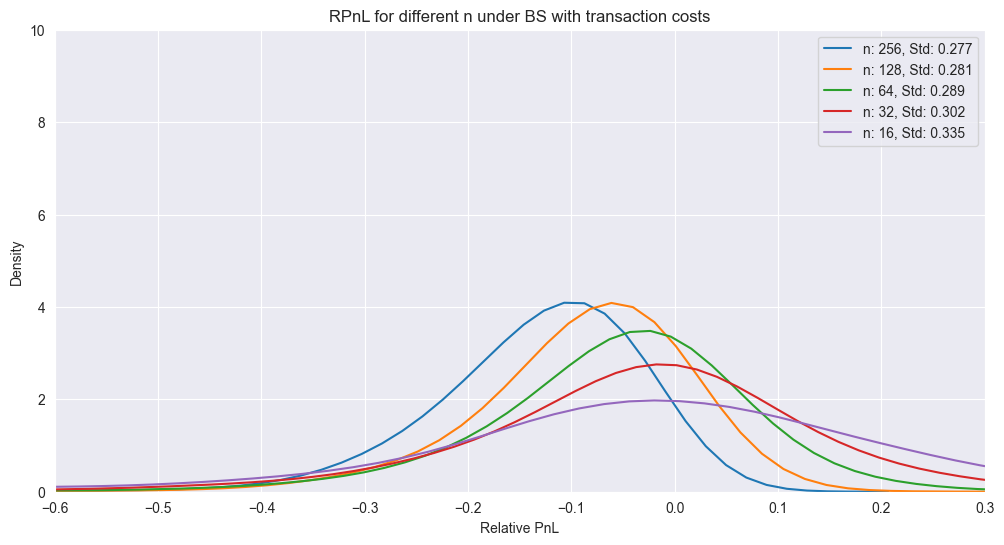

In [16]:
plt.figure(figsize=(12, 6))

for pnl, rehedge_interval in zip(pnl_densities, rehedge_intervals):
    # add variance to 2 decimals
    sns.kdeplot(pnl, label=f"n: {trading_days//rehedge_interval}, Std: {stds[rehedge_intervals.index(rehedge_interval)]:.3f}")
plt.title("RPnL for different n under BS with transaction costs")
plt.xlim(-0.6, 0.3)
plt.ylim(0, 10)
plt.xlabel("Relative PnL")
plt.ylabel("Density")
plt.legend()
#plt.savefig("RPnL_density_BS_transact.png")
plt.show()


In [96]:
# for every rehedging frequency get mean, std of relative pnl, VaR, CVaR (90, 95, 99) and Sharpe Ratio
# put it into a pandas dataframe
import pandas as pd

metrics = []
for pnl, rehedge_interval in zip(pnl_densities, rehedge_intervals):
    metrics.append({
        "n": 256//rehedge_interval,
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "VaR 90": np.percentile(pnl, 10),
        "VaR 95": np.percentile(pnl, 5),
        "VaR 99": np.percentile(pnl, 1),
        "CVaR 90": np.mean(pnl[pnl <= np.percentile(pnl, 10)]),
        "CVaR 95": np.mean(pnl[pnl <= np.percentile(pnl, 5)]),
        "CVaR 99": np.mean(pnl[pnl <= np.percentile(pnl, 1)]),
    })
    
metrics_df = pd.DataFrame(metrics)
metrics_df

,n,Mean,Std,VaR 90,VaR 95,VaR 99,CVaR 90,CVaR 95,CVaR 99
0,256,-0.330804,0.283077,-0.509631,-0.608323,-1.724964,-0.896263,-1.245380,-2.299378
1,128,-0.242436,0.280605,-0.392516,-0.515533,-1.641069,-0.814309,-1.188042,-2.222917
2,64,-0.178930,0.284571,-0.343707,-0.483577,-1.591643,-0.776209,-1.150169,-2.135179
3,32,-0.132235,0.300702,-0.344533,-0.530668,-1.555542,-0.773646,-1.129084,-2.087881
4,16,-0.100524,0.333946,-0.386906,-0.594390,-1.454288,-0.812906,-1.150996,-2.038042


In [97]:
# round the values to 3 decimals
metrics_df = metrics_df.round(3)
# let n be the index
#metrics_df.set_index("n", inplace=True)
# remove trailing zeros
metrics_df = metrics_df.astype(str).replace("000", "", regex=True)
print(metrics_df.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & n & Mean & Std & VaR 90 & VaR 95 & VaR 99 & CVaR 90 & CVaR 95 & CVaR 99 \\
\midrule
0 & 256 & -0.331 & 0.283 & -0.51 & -0.608 & -1.725 & -0.896 & -1.245 & -2.299 \\
1 & 128 & -0.242 & 0.281 & -0.393 & -0.516 & -1.641 & -0.814 & -1.188 & -2.223 \\
2 & 64 & -0.179 & 0.285 & -0.344 & -0.484 & -1.592 & -0.776 & -1.15 & -2.135 \\
3 & 32 & -0.132 & 0.301 & -0.345 & -0.531 & -1.556 & -0.774 & -1.129 & -2.088 \\
4 & 16 & -0.101 & 0.334 & -0.387 & -0.594 & -1.454 & -0.813 & -1.151 & -2.038 \\
\bottomrule
\end{tabular}



In [132]:
# use the dynamic_hedge_options
hedging_options = [('put', 80), ('put', 90), ('call', 100), ('call', 110), ('call', 120)]

portfolio_values, relative_pnl = dynamic_hedge_options(
        paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost, hedging_options
    )

C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


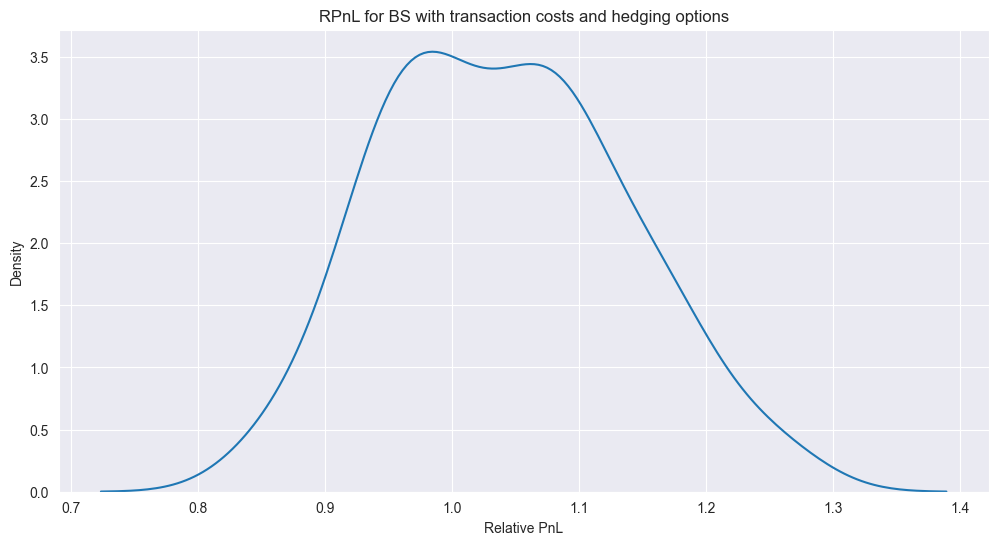

In [133]:
# plot density
plt.figure(figsize=(12, 6))
sns.kdeplot(relative_pnl)
plt.title("RPnL for BS with transaction costs and hedging options")

plt.xlabel("Relative PnL")
plt.ylabel("Density")
plt.show()


In [95]:
import numpy as np

def options_hedge_simulation(paths, K, r, sigma, T, dt, hedging_options, transaction_cost):
    N = paths.shape[1]
    n_steps = paths.shape[0] - 1
    B0 = 1  # Initial bond price

    portfolio_values = np.zeros_like(paths)
    relative_pnl = np.zeros(N)
    
    # Helper function to setup or reset hedging options
    def setup_hedging_options(S, current_time):
        options = []
        for opt_type, strike, exp in hedging_options:
            if opt_type == 'call':
                value = merton_jump_call(S, strike, exp - current_time, r, sigma, mu_J, sigma_J, lam)
            else:
                value = merton_jump_put(S, strike, exp - current_time, r, sigma, mu_J, sigma_J, lam)
            options.append({'type': opt_type, 'strike': strike, 'expiry': current_time + exp, 'value': value, 'cost': value})
        return options

    for j in range(N):
        cash = 0
        stock_held = 0
        bond_held = B0
        initial_V_call = merton_jump_call(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        initial_V_put = merton_jump_put(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        cash += initial_V_call + initial_V_put  # initial proceeds from selling main options
        hedging_positions = setup_hedging_options(paths[0, j], 0)
        cash -= sum(opt['cost'] for opt in hedging_positions)  # pay for initial hedging options

        for i in range(n_steps):
            S = paths[i, j]
            t = i * dt

            # Remove expired options and collect their payoffs
            active_options = []
            for opt in hedging_positions:
                if t >= opt['expiry']:
                    # Calculate and add payoff
                    payoff = max(0, S - opt['strike']) if opt['type'] == 'call' else max(0, opt['strike'] - S)
                    cash += payoff
                else:
                    active_options.append(opt)
            
            hedging_positions = active_options  # Update with only active options

            # Replenish expired options if necessary
            if len(hedging_positions) < len(hedging_options):  # Check if some options have expired
                new_options = setup_hedging_options(S, t)
                hedging_positions.extend(new_options)
                cash -= sum(opt['cost'] for opt in new_options)  # pay for new hedging options

            # Update bond and cash balance
            bond_held *= np.exp(r * dt)
            cash *= np.exp(r * dt)
            
            # Update portfolio value
            portfolio_values[i, j] = stock_held * S + cash + bond_held * B0 + sum(opt['value'] for opt in hedging_positions)

        # Final step calculation
        ST = paths[-1, j]
        VT_call = merton_jump_call(ST, K, 0, r, sigma, mu_J, sigma_J, lam)
        VT_put = merton_jump_put(ST, K, 0, r, sigma, mu_J, sigma_J, lam)
        final_value = stock_held * ST + cash + bond_held * B0 - VT_call - VT_put
        portfolio_values[-1, j] = final_value
        relative_pnl[j] = np.exp(-r * T) * (final_value / (initial_V_call + initial_V_put))
        
    return portfolio_values, relative_pnl


In [96]:
import numpy as np

def quarterly_hedge_simulation(paths, K, r, sigma, T, trading_days, hedging_options, transaction_cost, mu_J, sigma_J, lam):
    N = paths.shape[1]
    quarter_steps = 64  # Process every 64 steps (quarterly for 256 trading days)
    n_steps = paths.shape[0] - 1
    B0 = 1  # Initial bond price

    portfolio_values = np.zeros_like(paths)
    relative_pnl = np.zeros(N)
    
    # Helper function to setup or reset hedging options
    def setup_hedging_options(S, current_time):
        options = []
        for opt_type, strike, exp in hedging_options:
            if opt_type == 'call':
                value = merton_jump_call(S, strike, exp - current_time, r, sigma, mu_J, sigma_J, lam)
            else:
                value = merton_jump_put(S, strike, exp - current_time, r, sigma, mu_J, sigma_J, lam)
            options.append({'type': opt_type, 'strike': strike, 'expiry': current_time + exp, 'value': value, 'cost': value})
        return options

    for j in range(N):
        cash = 0
        stock_held = 0
        bond_held = B0
        initial_V_call = merton_jump_call(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        initial_V_put = merton_jump_put(paths[0, j], K, T, r, sigma, mu_J, sigma_J, lam)
        cash += initial_V_call + initial_V_put  # initial proceeds from selling main options
        hedging_positions = setup_hedging_options(paths[0, j], 0)
        cash -= sum(opt['cost'] for opt in hedging_positions)  # pay for initial hedging options

        for i in range(0, n_steps + 1, quarter_steps):  # Skip to each quarter
            if i > 0:
                S = paths[i, j]
                t = i * 1 / trading_days  # Convert steps to time in years

                # Calculate and collect payoffs for expired options
                for opt in hedging_positions:
                    if t >= opt['expiry']:
                        payoff = max(0, S - opt['strike']) if opt['type'] == 'call' else max(0, opt['strike'] - S)
                        cash += payoff

                # Repurchase the same set of hedging options
                hedging_positions = setup_hedging_options(S, t)
                costs = sum(opt['cost'] for opt in hedging_positions)
                trans_costs = costs * transaction_cost
                cash -= costs + trans_costs

            # Update bond and cash balance
            bond_held *= np.exp(r * (quarter_steps / trading_days))
            cash *= np.exp(r * (quarter_steps / trading_days))
            
            # Update portfolio value
            portfolio_values[i, j] = stock_held * paths[i, j] + cash + bond_held * B0 + sum(opt['value'] for opt in hedging_positions)

        # Final step calculation
        ST = paths[-1, j]
        VT_call = merton_jump_call(ST, K, 0, r, sigma, mu_J, sigma_J, lam)
        VT_put = merton_jump_put(ST, K, 0, r, sigma, mu_J, sigma_J, lam)
        final_value = stock_held * ST + cash + bond_held * B0 - VT_call - VT_put
        portfolio_values[-1, j] = final_value
        relative_pnl[j] = np.exp(-r * T) * (final_value / (initial_V_call + initial_V_put))
        
    return portfolio_values, relative_pnl


In [135]:
hedging_options = [('call', 110, 0.25), ('call', 120, 0.25), ('call', 130, 0.25),
                   ('put', 90, 0.25), ('put', 80, 0.25)]

# alternate between call and put, starting with call, moving away 10 from K
H1 = [("call", 100)]
H2 = [("call", 100), ("put", 90)]
H3 = [("call", 100), ("put", 90), ("call", 110)]
H4 = [("call", 100), ("put", 90), ("call", 110), ("put", 80)]
H5 = [("call", 100), ("put", 90), ("call", 110), ("put", 80), ("call", 120)]


In [140]:
# do the same for all hedging options
hedging_options = [H1, H2, H3, H4, H5]
pnl_densities = []

for hedging_option in hedging_options:
    portfolio_values, relative_pnl = dynamic_hedge_options(
        paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost, hedging_option
    )
    pnl_densities.append(relative_pnl)
    
# stds


C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21764\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [143]:
# subtract 1 from the relative pnl
pnl_densities = [pnl - 1 for pnl in pnl_densities]


In [157]:
pnl_densities = [pnl * 10 for pnl in pnl_densities]

In [158]:
stds = [np.std(pnl) for pnl in pnl_densities]

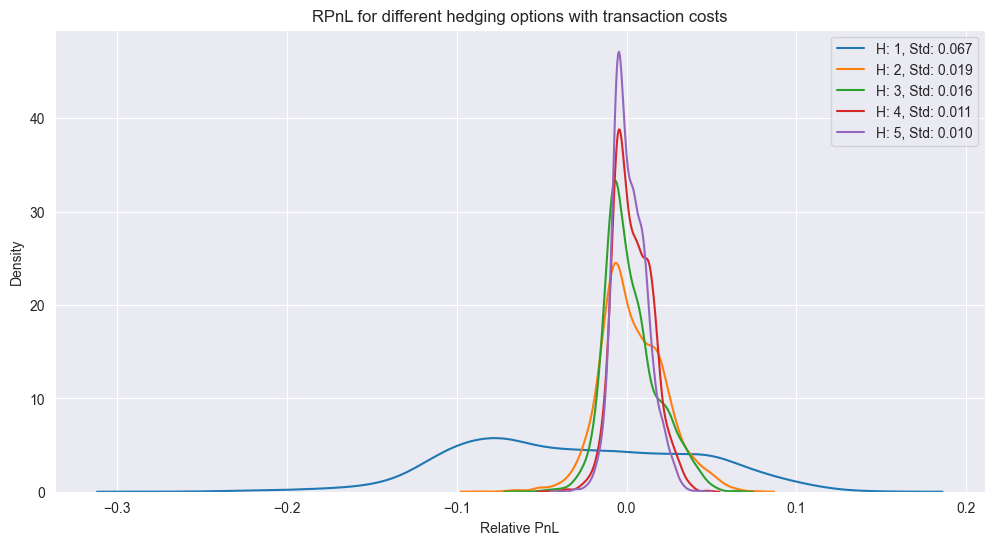

In [161]:
# plot density
plt.figure(figsize=(12, 6))


for pnl, hedging_option in zip(pnl_densities, hedging_options):
    # add variance to 2 decimals
    sns.kdeplot(pnl, label=f"H: {len(hedging_option)}, Std: {stds[hedging_options.index(hedging_option)]:.3f}")
plt.title("RPnL for different hedging options with transaction costs")

plt.xlabel("Relative PnL")
plt.ylabel("Density")
plt.legend()
plt.savefig("RPnL_density_JD_transact_hedging_options.png")
plt.show()

In [160]:
# get metrics
metrics = []
for pnl, hedging_option in zip(pnl_densities, hedging_options):
    metrics.append({
        "Hedging Options": len(hedging_option),
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "VaR 90": np.percentile(pnl, 10),
        "VaR 95": np.percentile(pnl, 5),
        "VaR 99": np.percentile(pnl, 1),
        "CVaR 90": np.mean(pnl[pnl <= np.percentile(pnl, 10)]),
        "CVaR 95": np.mean(pnl[pnl <= np.percentile(pnl, 5)]),
        "CVaR 99": np.mean(pnl[pnl <= np.percentile(pnl, 1)]),
    })
    
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(3)
metrics_df = metrics_df.astype(str).replace("000", "", regex=True)
print(metrics_df.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & Hedging Options & Mean & Std & VaR 90 & VaR 95 & VaR 99 & CVaR 90 & CVaR 95 & CVaR 99 \\
\midrule
0 & 1 & -0.031 & 0.067 & -0.112 & -0.129 & -0.183 & -0.14 & -0.16 & -0.209 \\
1 & 2 & 0.004 & 0.019 & -0.017 & -0.024 & -0.04 & -0.027 & -0.034 & -0.052 \\
2 & 3 & 0.002 & 0.016 & -0.014 & -0.018 & -0.029 & -0.02 & -0.025 & -0.036 \\
3 & 4 & 0.004 & 0.011 & -0.009 & -0.013 & -0.021 & -0.014 & -0.018 & -0.027 \\
4 & 5 & 0.002 & 0.01 & -0.009 & -0.011 & -0.018 & -0.013 & -0.016 & -0.023 \\
\bottomrule
\end{tabular}



In [156]:
# print means
for pnl, hedging_option in zip(pnl_densities, hedging_options):
    print(np.mean(pnl))

-0.0031072258963846626
0.0003755474780293202
0.0002412578433366355
0.00036576643286231566
0.0002245877563462677


In [98]:
transaction_cost = 0

In [99]:
# Run the hedge simulation
portfolio_values, relative_pnl = options_hedge_simulation(
    paths, K, r, sigma, T, 1/256, hedging_options, transaction_cost
)

In [100]:
portfolio_values, relative_pnl = quarterly_hedge_simulation(
    paths, K, r, sigma, T, 256, hedging_options, transaction_cost, mu_J, sigma_J, lam
)

In [102]:
# do the same for different amount of hedging options
h1 = [('put', 80, 0.25), ('put', 90, 0.25)]
h2 = [('put', 80, 0.25), ('put', 90, 0.25), ('call', 100, 0.25)]
h3 = [('put', 80, 0.25), ('put', 90, 0.25), ('call', 100, 0.25), ('call', 110, 0.25)]
h4 = [('put', 80, 0.25), ('put', 90, 0.25), ('call', 100, 0.25), ('call', 110, 0.25), ('call', 120, 0.25)]

hedging_options = [h1, h2, h3, h4]
pnl_densities = []

for hedging_option in hedging_options:
    portfolio_values, relative_pnl = quarterly_hedge_simulation(
        paths, K, r, sigma, T, 256, hedging_option, transaction_cost, mu_J, sigma_J, lam
    
    )
    pnl_densities.append(relative_pnl)
    
    

In [ ]:
# get variances of the relative pnl


# div by 100
pnl_densities = [pnl / 100 for pnl in pnl_densities]
stds = [np.std(pnl) for pnl in pnl_densities]

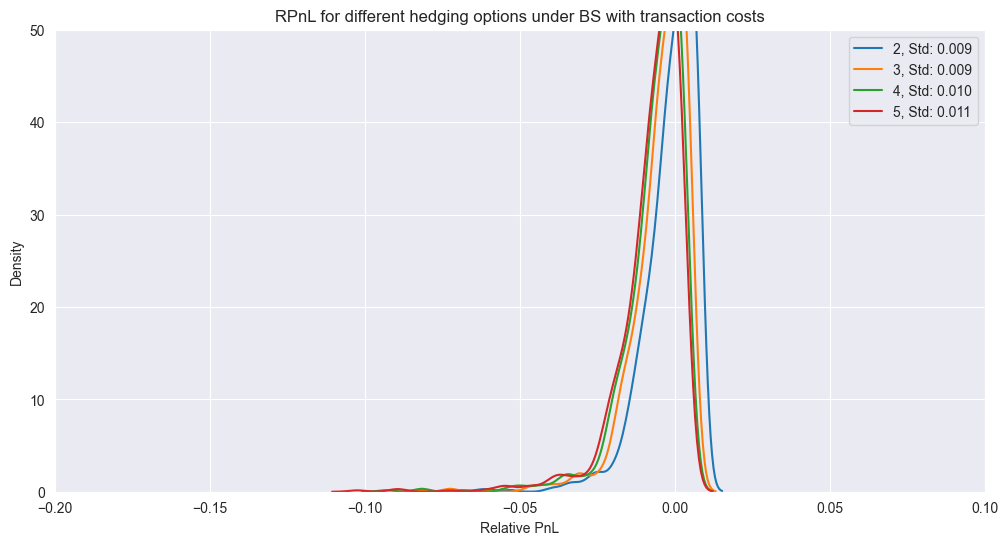

In [108]:

# plot
plt.figure(figsize=(12, 6))

for pnl, hedging_option in zip(pnl_densities, hedging_options):
    # add variance to 2 decimals
    sns.kdeplot(pnl, label=f"{len(hedging_option)}, Std: {stds[hedging_options.index(hedging_option)]:.3f}")
plt.title("RPnL for different hedging options under BS with transaction costs")
plt.xlim(-0.2, 0.1)
plt.ylim(0, 50)
plt.xlabel("Relative PnL")
plt.ylabel("Density")
plt.legend()
#plt.savefig
plt.show()

In [78]:
# divide relative pnl by 1000
relative_pnl = relative_pnl / 100

In [79]:
relative_pnl.std()

0.009781180098161946

In [80]:
relative_pnl.mean()

-0.00486867551099183

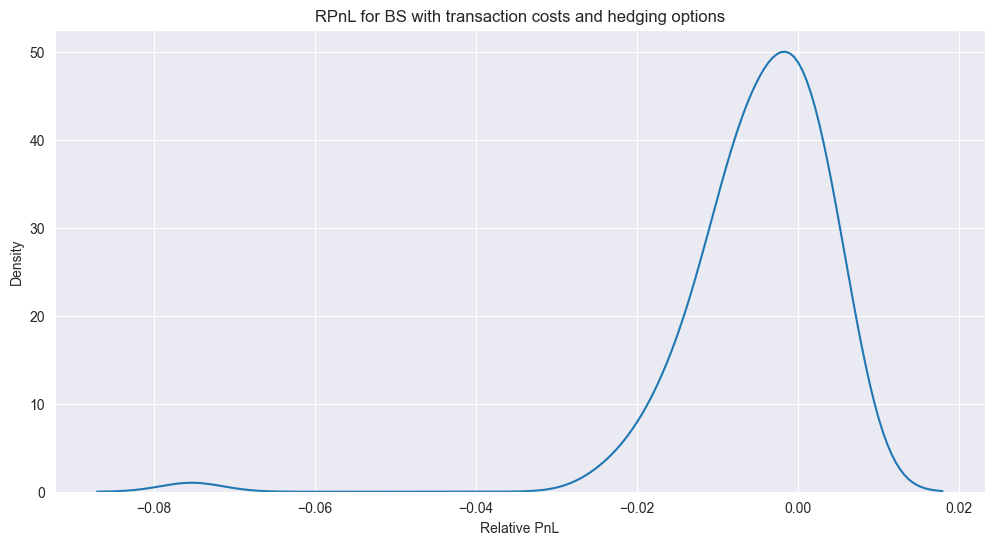

In [81]:
# plot density
plt.figure(figsize=(12, 6))
sns.kdeplot(relative_pnl)
plt.title("RPnL for BS with transaction costs and hedging options")

plt.xlabel("Relative PnL")
plt.ylabel("Density")
plt.show()